In [1]:
# Standard modules
import pdb
import os
import sys
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec

from lmfit import Parameters, minimize, fit_report

import warnings
warnings.filterwarnings("ignore")

sys.path.append("../../../..")

from simstackwrapper import SimstackWrapper
from simstackresults import SimstackResults
from simstackplots import SimstackPlots
from simstacktoolbox import SimstackToolbox

#from scipy.signal import find_peaks
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### COSMOS2020 Catalog

In [2]:
# Import catalog with SimstackWrapper
combined_pickle_filename = "cosmos2020_farmer_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8_10p0_X_4_foregnd_atonce_bootstrap_1-150"
combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", "spire" , combined_pickle_filename)
underscore_suffix = ""
path_ini_file = os.path.join(combined_pickle_path, "cosmos2020_farmer.ini")
path_pickle_file = os.path.join(combined_pickle_path, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [3]:
# Load Table into a pandas DataFrame
cosmos2020 = simstack_catalog_object.catalog_dict['tables']['full_table']

### SIDES Catalog

In [4]:
# Import catalog with SimstackWrapper
combined_pickle_filename = "sides_allz_nuvrj_0p01_0p5_1_1p5_2_2p5_3_4_5_6p0_X_4_foregnd_atonce_bootstrap_1-70"
combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", "spire" , combined_pickle_filename)
underscore_suffix = ""
path_ini_file = os.path.join(combined_pickle_path, "sides_simulation.ini")
path_pickle_file = os.path.join(combined_pickle_path, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    sides_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

### Compare Counts

In [5]:
def plot_number_counts_comparison(self, catalog, sides, id_label = None, 
                                  area_sides = 2, area_c2022 = 1.65):

    bin_keys = list(self.config_dict['parameter_names'].keys())
    wv_keys = list(self.results_dict['band_results_dict'].keys())
    
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    wlen = len(wv_keys)
    
    wv_mod = np.linspace(8,1000,1000)
    
    if id_label is not None:
        zlab = id_label.split('__')[0]
        mlab = id_label.split('__')[1]
        plab = id_label.split('__')[2]
        m = [float(i) for i in mlab.split('_')[2:]]
        z = [float(i) for i in zlab.split('_')[1:]]
        print(z, m)
        ind_bin = (catalog['lp_zBEST'] > z[0]) & \
            (catalog['lp_zBEST'] < z[1]) & \
            (catalog['lp_mass_med'] >= m[0]) & \
            (catalog['lp_mass_med'] < m[1]) & \
            (catalog['sfg'] == 1)
        idz=catalog.ID[ind_bin].values
        
        #subsides = sides[(sides['Mstar']>10**m[0]) & (sides['Mstar']<10**m[1]) & (sides['qflag']==0)]
        subsides_bin = sides[(sides['redshift']>z[0]) & (sides['redshift']<z[1]) & (sides['Mstar']>10**m[0]) & (sides['Mstar']<10**m[1]) & (sides['qflag']==0)]

        print(id_label," SIDES={0:0d}, Cosmos2020={1:0d}".format(len(subsides_bin),len(idz)))
    else:
        
        number_counts = np.zeros([2,zlen,mlen+1])
        width_ratios = [i for i in np.ones(zlen)]
        gs = gridspec.GridSpec(2, zlen, width_ratios=width_ratios,
                               wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
        fig = plt.figure(figsize=(35, 5))
        for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
            for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
                if ip:
                    ax = plt.subplot(gs[0, iz])                
                    #ax.set_xscale('log')                
                    ax.set_yscale('log')      
                    ax.set_ylim([1e1,2e4])
                    ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))
                
                    mx=np.zeros(mlen+1)
                    for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                        id_label = "__".join([zlab, mlab, plab])
                        
                        m = [float(i) for i in mlab.split('_')[2:]]
                        z = [float(i) for i in zlab.split('_')[1:]]
                        mx[im] = m[0]

                        ind_bin = (catalog['lp_zBEST'] > z[0]) & \
                        (catalog['lp_zBEST'] < z[1]) & \
                        (catalog['lp_mass_med'] >= m[0]) & \
                        (catalog['lp_mass_med'] < m[1]) & \
                        (catalog['sfg'] == ip)
                        idz=catalog.ID[ind_bin].values
                        
                        subsides_bin = sides[(sides['redshift']>=z[0]) & (sides['redshift']<z[1]) & (sides['Mstar']>=10**m[0]) & (sides['Mstar']<10**m[1]) & (sides['qflag']==0)]
                        
                        number_counts[:,iz,im+1] = len(subsides_bin),len(idz)
                    
                    number_counts[:,iz,0] = number_counts[:,iz,1] 
                    mx[-1] = m[1]
                    
                    v_sides = self.comoving_volume_given_area(area_sides, z[0], z[1])
                    v_c2020 = self.comoving_volume_given_area(area_c2022, z[0], z[1])
                    ax.step(mx,number_counts[0,iz,:]*(v_c2020/v_sides),c='r' ,label='sides')
                    ax.step(mx,number_counts[1,iz,:],c='b' ,label='cosmos2020')
                    
                    ax.set_xlabel('stellar mass')

                    if iz:
                        ax.set_yticklabels([])
                    else:
                        ax.set_ylabel('counts')
                        
                    if iz == 1:
                        ax.legend()
                        
                    ax = plt.subplot(gs[1, iz])                   
                    ax.set_ylim([.1,20])
                    ax.set_yscale('log')      
                    counts_ratio = (number_counts[1,iz,:])/(number_counts[0,iz,:]*(v_c2020/v_sides))
                    plt.step(mx, counts_ratio)
                    if iz:
                        ax.set_yticklabels([])
                    else:
                        ax.set_ylabel('N_cosmos/N_sides')
                        

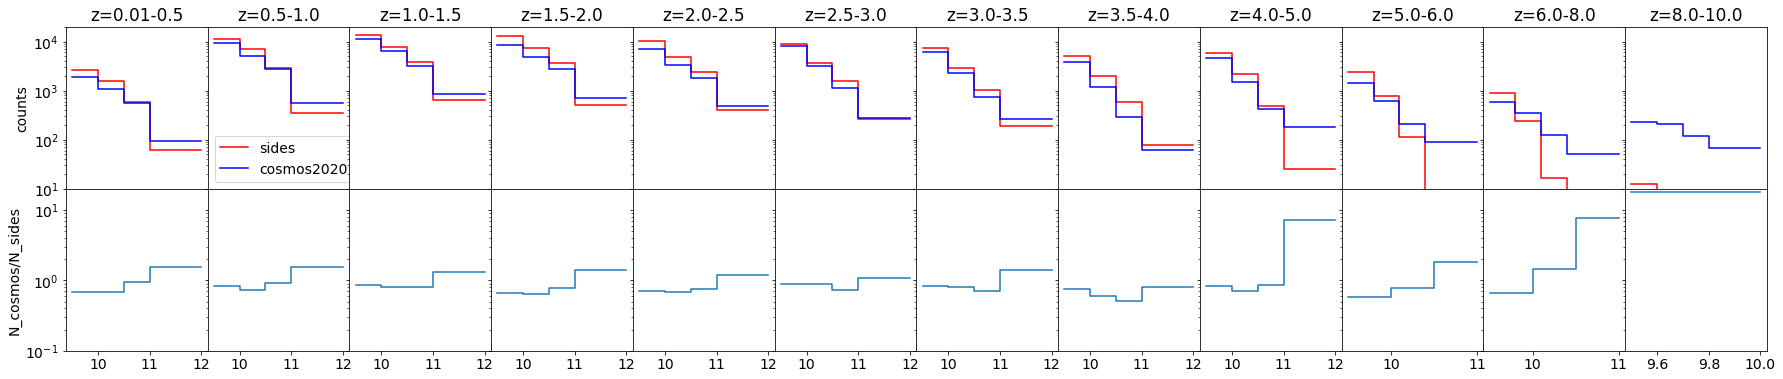

In [6]:
plot_number_counts_comparison(simstack_catalog_object, cosmos2020, sides_catalog_object.catalog_dict['tables']['full_table'])